This assumes that you have run the following in the terminal before starting up the ipython notebook:

```
source $HOME/loadLSST.bash
setup pipe_tasks
```

In [12]:
import lsst.afw.math        as math
import lsst.afw.table       as afwTable
import lsst.afw.image       as afwImg
import lsst.afw.detection   as afwDetect
import lsst.meas.algorithms as measAlg

%matplotlib inline
from matplotlib.colors  import LogNorm
import matplotlib.pyplot as plt

# User Input

In [21]:
# name of the fits file
fitsfile = '../TestData/test_lsst_image_paper1_ex1.fits'
# gain; once this is in the fits header it should be read from that using metaData = exposure.getMetadata()
gain = 2.1

In [35]:
# load the fits image into an exposure
exposure = afwImg.ExposureF(fitsfile)

# add links to the various exposure parts
maskedImage = exposure.getMaskedImage()
image = maskedImage.getImage()
mask = maskedImage.getMask()
variance = maskedImage.getVariance()

In [38]:
## Note that we need to manually make the variance image; lets just define
## this a image pixel values / gain
variance_array = variance.getArray()
image_array = image.getArray()
variance_array[:] = image_array / gain

<matplotlib.colorbar.Colorbar instance at 0x114f1cb48>

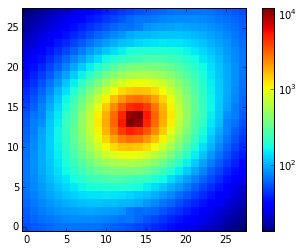

In [42]:
plt.imshow(image.getArray(),norm=LogNorm(),origin='lower',interpolation='nearest')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x1154d5ab8>

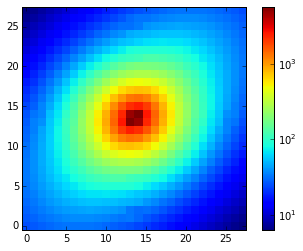

In [43]:
plt.imshow(variance.getArray(),norm=LogNorm(),origin='lower',interpolation='nearest')
plt.colorbar()

In [99]:
# Configure the detection and measurement algorithms
schema                = afwTable.SourceTable.makeMinimalSchema()
detectSourcesConfig   = measAlg.SourceDetectionConfig(thresholdType='value')
# turn off the background reestimation since this is such a small field, otherwise it won't
# will not detect the source due to subtracting it as background
detectSourcesConfig.reEstimateBackground = False
#detectSourcesConfig   = measAlg.SourceDetectionConfig(thresholdType='value',thresholdValue=0)
#detectSourcesConfig   = measAlg.SourceDetectionConfig(thresholdType='pixel_stdev')
measureSourcesConfig  = measAlg.SourceMeasurementConfig()

In [100]:
# Setup the detection and measurement tasks
detect  = measAlg.SourceDetectionTask(config=detectSourcesConfig,  schema=schema)
measure = measAlg.SourceMeasurementTask(config=measureSourcesConfig, schema=schema)

# Set flux aliases to None; a hack for an incompatability between
# makeMinimalSchema() and the default SourceMeasurementConfig() options.
measureSourcesConfig.slots.psfFlux    = None
measureSourcesConfig.slots.apFlux     = None
measureSourcesConfig.slots.modelFlux  = None
measureSourcesConfig.slots.instFlux   = None
measureSourcesConfig.validate()

In [136]:
# Detect the sources,then put them into a catalog (the table is where the
# catalog atually stores stuff)
table   = afwTable.SourceTable.make(schema)
catalog = detect.makeSourceCatalog(table, exposure, sigma=3)

In [137]:
# Get the sources out of the catalog
sources = catalog.sources

# Apply the measurement routines to the exposure using the sources as input
measure.run(exposure, sources)

# Now let's look at the output from some of the measurment algorithms.
fields = ['centroid.sdss', 'shape.sdss', 'shape.sdss.centroid','flux.gaussian']
keys   = [schema.find(f).key for f in fields]

for source in sources:
    print source.getCentroid() #This uses one of the aliases

    # Now loop through the keys we want
    for f,k in zip(fields, keys):
        print '    ', f, source.get(k)


(13.44, 13.437)
     centroid.sdss (13.44, 13.437)
     shape.sdss (ixx=3.63687392279, iyy=3.17690277203, ixy=0.487577036626)
     shape.sdss.centroid (13.47, 13.468)
     flux.gaussian 199082.285648


In [138]:
# look at the detected objects in ds9
import lsst.afw.display.ds9 as ds9
#ds9.setMaskPlaneVisibility("DETECTED",False)
ds9.setMaskTransparency(75)
ds9.mtv(maskedImage)
ds9.dot("+", source.getX(), source.getY())

ds9 doesn't appear to be running (XPA: XPA returned NULL, (;iconify no; raise)), I'll exec it for you


Something seems off about the properties of the detected source. It is strange that the footprint in the ds9 display looks round and it is suprising that ixy of shape.sdss is so much smaller than ixx and iyy since this object has a clearly diagonally orientated ellipticity. This could be OK though since the ellipticity is primarily present in a log streach of the data. I need to do some independent basic measurements of the data to make sure I understand the results.

In [129]:
# look at the fields that have calculated and can be called
source.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Coord'](name="coord", doc="position in ra/dec", units="IRCS; radians"), Key<Coord>(offset=8, nElements=2)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="flags.badcentroid", doc="the centroid algorithm used to feed centers to other algorithms failed"), Key['Flag'](offset=32, bit=1)),
    (Field['PointD'](name="centroid.sdss", doc="SDSS-algorithm centroid measurement", units="pixels"), Key<PointD>(offset=40, nElements=2)),
    (Field['CovPointF'](name="centroid.sdss.err", doc="covariance matrix for centroid.sdss", units="pixels^2"), Key<CovPointF>(offset=56, nElements=3)),
    (Field['Flag'](name="centroid.sdss.flags", doc="set if the centroid.sdss measurement did not fully succeed"

In [ ]:
source.getShape()

Note that originally the above did not work. I think it is because the image is too small for the detection scheme to acurately determine the background. So in what follows I use a more manual method of detection.

In [76]:
thresholdValue = 100
npixMin        = 5 
grow           = 1
isotropic      = False

#threshold = afwDetect.Threshold(thresholdValue, afwDetect.Threshold.VALUE)
threshold = afwDetect.Threshold(thresholdValue)
footPrintSet  = afwDetect.FootprintSet(maskedImage, threshold, "DETECTED", npixMin)
footPrintSet  = afwDetect.FootprintSet(footPrintSet, grow, isotropic)

footPrints = footPrintSet.getFootprints()

footPrintSet.setMask(maskedImage.getMask(), "DETECTED")

In [77]:
print "I found ", footPrints.size(), "footPrint(s)"
print

for i in range(0,footPrints.size()):
    print "Footprint:",i
    
    peak = footPrints[i].getPeaks()[0]
    print "A peak of value", peak.getPeakValue()
    print "was found at X =", peak.getFx(),"Y =",peak.getFy()

I found  1 footPrint(s)

Footprint: 0
A peak of value 12165.3378906
was found at X = 13.0 Y = 13.0


In [80]:
help(afwDetect.Footprint)

Help on class Footprint in module lsst.afw.detection.detectionLib:

class Footprint(lsst.daf.base.baseLib.Citizen, FootprintPersistableFacade, lsst.afw.table.io.ioLib.Persistable)
 |  Proxy of C++ lsst::afw::detection::Footprint class
 |  
 |  Method resolution order:
 |      Footprint
 |      lsst.daf.base.baseLib.Citizen
 |      FootprintPersistableFacade
 |      lsst.afw.table.io.ioLib.Persistable
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      __init__(lsst::afw::detection::Footprint self, int nspan=0, Box2I region=lsst::afw::geom::Box2I()) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self, int nspan=0) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self, Box2I bbox, Box2I region=lsst::afw::geom::Box2I()) -> Footprint
 |      __init__(lsst::afw::detection::Footprint se

In [81]:
reg = footPrints[0].getRegion()

In [92]:
footPrints[0].getBBox()

Box2I(Point2I(2, 2), Extent2I(24, 24))

In [98]:
help(footPrints[0])

Help on Footprint in module lsst.afw.detection.detectionLib object:

class Footprint(lsst.daf.base.baseLib.Citizen, FootprintPersistableFacade, lsst.afw.table.io.ioLib.Persistable)
 |  Proxy of C++ lsst::afw::detection::Footprint class
 |  
 |  Method resolution order:
 |      Footprint
 |      lsst.daf.base.baseLib.Citizen
 |      FootprintPersistableFacade
 |      lsst.afw.table.io.ioLib.Persistable
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __del__ lambda self
 |  
 |  __getattr__ lambda self, name
 |  
 |  __init__(self, *args)
 |      __init__(lsst::afw::detection::Footprint self, int nspan=0, Box2I region=lsst::afw::geom::Box2I()) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self, int nspan=0) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self) -> Footprint
 |      __init__(lsst::afw::detection::Footprint self, Box2I bbox, Box2I region=lsst::afw::geom::Box2I()) -> Footprint
 |      __init__(lsst::afw::detection::Footprint s

In [97]:
footPrints[0].insertIntoImage

AttributeError: getArray